In [3]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# @title Figure Settings
import ipywidgets as widgets  # interactive display
%config InlineBackend.figure_format = 'retina'
# use NMA plot style
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")
my_layout = widgets.Layout()

In [5]:
# @title Plotting Functions

def plot_volt_trace(pars, v, sp):
  """
  Plot trajetory of membrane potential for a single neuron

  Expects:
  pars   : parameter dictionary
  v      : volt trajetory
  sp     : spike train

  Returns:
  figure of the membrane potential trajetory for a single neuron
  """

  V_th = pars['V_th']
  dt, range_t = pars['dt'], pars['range_t']
  if sp.size:
    sp_num = (sp / dt).astype(int) - 1
    v[sp_num] += 20  # draw nicer spikes

  plt.plot(pars['range_t'], v, 'b')
  plt.axhline(V_th, 0, 1, color='k', ls='--')
  plt.xlabel('Time (ms)')
  plt.ylabel('V (mV)')
  plt.legend(['Membrane\npotential', r'Threshold V$_{\mathrm{th}}$'],
             loc=[1.05, 0.75])
  plt.ylim([-80, -40])


def plot_GWN(pars, I_GWN):
  """
  Args:
    pars  : parameter dictionary
    I_GWN : Gaussian white noise input

  Returns:
    figure of the gaussian white noise input
  """

  plt.figure(figsize=(12, 4))
  plt.subplot(121)
  plt.plot(pars['range_t'][::3], I_GWN[::3], 'b')
  plt.xlabel('Time (ms)')
  plt.ylabel(r'$I_{GWN}$ (pA)')
  plt.subplot(122)
  plot_volt_trace(pars, v, sp)
  plt.tight_layout()


def my_hists(isi1, isi2, cv1, cv2, sigma1, sigma2):
  """
  Args:
    isi1 : vector with inter-spike intervals
    isi2 : vector with inter-spike intervals
    cv1  : coefficient of variation for isi1
    cv2  : coefficient of variation for isi2

  Returns:
    figure with two histograms, isi1, isi2

  """
  plt.figure(figsize=(11, 4))
  my_bins = np.linspace(10, 30, 20)
  plt.subplot(121)
  plt.hist(isi1, bins=my_bins, color='b', alpha=0.5)
  plt.xlabel('ISI (ms)')
  plt.ylabel('count')
  plt.title(r'$\sigma_{GWN}=$%.1f, CV$_{\mathrm{isi}}$=%.3f' % (sigma1, cv1))

  plt.subplot(122)
  plt.hist(isi2, bins=my_bins, color='b', alpha=0.5)
  plt.xlabel('ISI (ms)')
  plt.ylabel('count')
  plt.title(r'$\sigma_{GWN}=$%.1f, CV$_{\mathrm{isi}}$=%.3f' % (sigma2, cv2))
  plt.tight_layout()
  plt.show()

In [6]:
# @markdown Execute this code to initialize the default parameters


def default_pars(**kwargs):
  pars = {}

  # typical neuron parameters#
  pars['V_th'] = -55.     # spike threshold [mV]
  pars['V_reset'] = -75.  # reset potential [mV]
  pars['tau_m'] = 10.     # membrane time constant [ms]
  pars['g_L'] = 10.       # leak conductance [nS]
  pars['V_init'] = -75.   # initial potential [mV]
  pars['E_L'] = -75.      # leak reversal potential [mV]
  pars['tref'] = 2.       # refractory time (ms)

  # simulation parameters #
  pars['T'] = 400.  # Total duration of simulation [ms]
  pars['dt'] = .1   # Simulation time step [ms]

  # external parameters if any #
  for k in kwargs:
    pars[k] = kwargs[k]

  pars['range_t'] = np.arange(0, pars['T'], pars['dt'])  # Vector of discretized time points [ms]

  return pars


pars = default_pars()
print(pars)

{'V_th': -55.0, 'V_reset': -75.0, 'tau_m': 10.0, 'g_L': 10.0, 'V_init': -75.0, 'E_L': -75.0, 'tref': 2.0, 'T': 400.0, 'dt': 0.1, 'range_t': array([0.000e+00, 1.000e-01, 2.000e-01, ..., 3.997e+02, 3.998e+02,
       3.999e+02])}


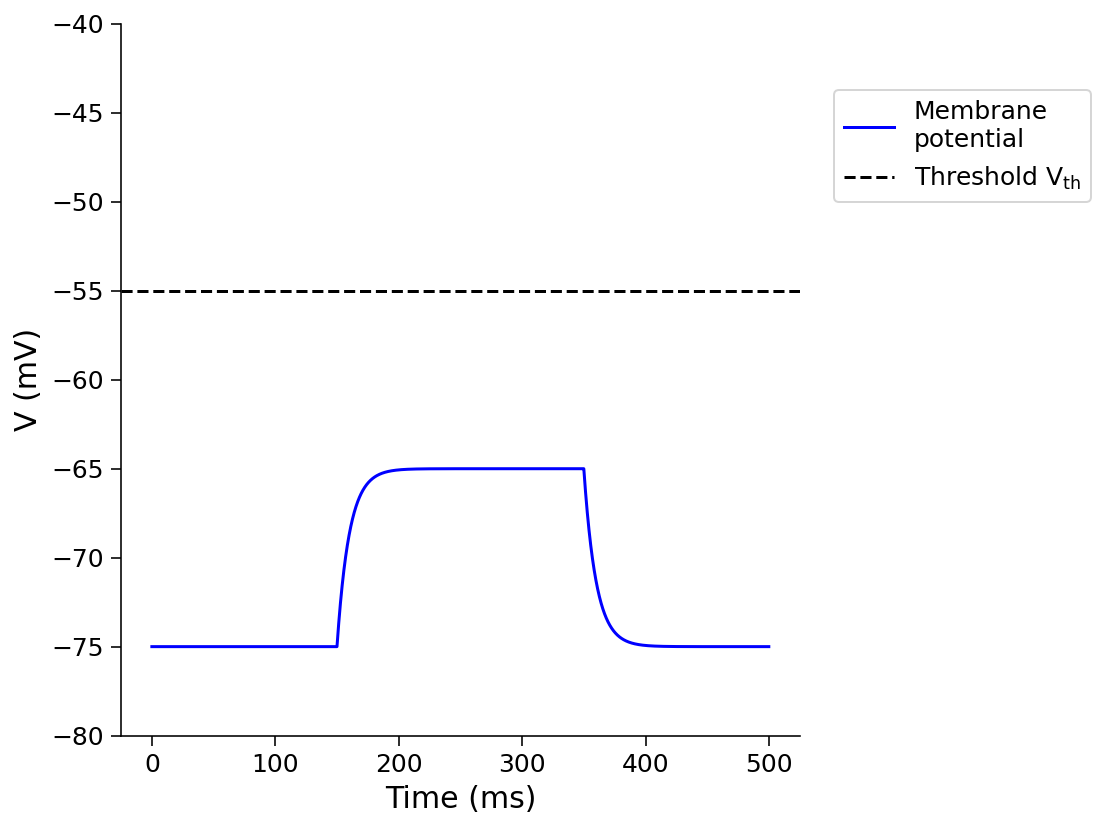

In [11]:
def run_LIF(pars, Iinj, stop=False):
  """
  Simulate the LIF dynamics with external input current

  Args:
    pars       : parameter dictionary
    Iinj       : input current [pA]. The injected current here can be a value
                 or an array
    stop       : boolean. If True, use a current pulse

  Returns:
    rec_v      : membrane potential
    rec_sp     : spike times
  """

  # Set parameters
  V_th, V_reset = pars['V_th'], pars['V_reset']
  tau_m, g_L = pars['tau_m'], pars['g_L']
  V_init, E_L = pars['V_init'], pars['E_L']
  dt, range_t = pars['dt'], pars['range_t']
  Lt = range_t.size
  tref = pars['tref']

  # Initialize voltage
  v = np.zeros(Lt)
  v[0] = V_init

  # Set current time course
  Iinj = Iinj * np.ones(Lt)

  # If current pulse, set beginning and end to 0
  if stop:
    Iinj[:int(len(Iinj) / 2) - 1000] = 0
    Iinj[int(len(Iinj) / 2) + 1000:] = 0

  # Loop over time
  rec_spikes = []  # record spike times
  tr = 0.  # the count for refractory duration

  for it in range(Lt - 1):

    if tr > 0:  # check if in refractory period
      v[it] = V_reset  # set voltage to reset
      tr = tr - 1 # reduce running counter of refractory period

    elif v[it] >= V_th:  # if voltage over threshold
      rec_spikes.append(it)  # record spike event
      v[it] = V_reset  # reset voltage
      tr = tref / dt  # set refractory time

    ########################################################################
    ## TODO for students: compute the membrane potential v, spike train sp #
    # Fill out function and remove
    #raise NotImplementedError('Student Exercise: calculate the dv/dt and the update step!')
    ########################################################################

    # Calculate the increment of the membrane potential
    dv = (-(v[it]-E_L)+ Iinj[it]/g_L)*dt/ tau_m

    # Update the membrane potential
    v[it + 1] = v[it]+dv

  # Get spike times in ms
  rec_spikes = np.array(rec_spikes) * dt

  return v, rec_spikes


# Get parameters
pars = default_pars(T=500)

# Simulate LIF model
v, sp = run_LIF(pars, Iinj=100, stop=True)

# Visualize
plot_volt_trace(pars, v, sp)


In [12]:
# @markdown Execute to enable helper function `my_GWN`

def my_GWN(pars, mu, sig, myseed=False):
  """
  Function that generates Gaussian white noise input

  Args:
    pars       : parameter dictionary
    mu         : noise baseline (mean)
    sig        : noise amplitute (standard deviation)
    myseed     : random seed. int or boolean
                 the same seed will give the same
                 random number sequence

  Returns:
    I          : Gaussian white noise input
  """

  # Retrieve simulation parameters
  dt, range_t = pars['dt'], pars['range_t']
  Lt = range_t.size

  # Set random seed
  if myseed:
      np.random.seed(seed=myseed)
  else:
      np.random.seed()

  # Generate GWN
  # we divide here by 1000 to convert units to sec.
  I_gwn = mu + sig * np.random.randn(Lt) / np.sqrt(dt / 1000.)

  return I_gwn

help(my_GWN)

Help on function my_GWN in module __main__:

my_GWN(pars, mu, sig, myseed=False)
    Function that generates Gaussian white noise input
    
    Args:
      pars       : parameter dictionary
      mu         : noise baseline (mean)
      sig        : noise amplitute (standard deviation)
      myseed     : random seed. int or boolean
                   the same seed will give the same
                   random number sequence
    
    Returns:
      I          : Gaussian white noise input



In [13]:
# @title

# @markdown Make sure you execute this cell to enable the widget!

my_layout.width = '450px'
@widgets.interact(
    mu_gwn=widgets.FloatSlider(200., min=100., max=300., step=5.,
                               layout=my_layout),
    sig_gwn=widgets.FloatSlider(2.5, min=0., max=5., step=.5,
                                layout=my_layout)
)


def diff_GWN_to_LIF(mu_gwn, sig_gwn):
  pars = default_pars(T=100.)
  I_GWN = my_GWN(pars, mu=mu_gwn, sig=sig_gwn)
  v, sp = run_LIF(pars, Iinj=I_GWN)
  plt.figure(figsize=(12, 4))
  plt.subplot(121)
  plt.plot(pars['range_t'][::3], I_GWN[::3], 'b')
  plt.xlabel('Time (ms)')
  plt.ylabel(r'$I_{GWN}$ (pA)')
  plt.subplot(122)
  plot_volt_trace(pars, v, sp)
  plt.tight_layout()
  plt.show()

interactive(children=(FloatSlider(value=200.0, description='mu_gwn', layout=Layout(width='450px'), max=300.0, …

In [14]:
# @title

# @markdown Make sure you execute this cell to enable the widget!


my_layout.width = '450px'
@widgets.interact(
    sig_gwn=widgets.FloatSlider(3.0, min=0., max=6., step=0.5,
                                layout=my_layout)
)


def diff_std_affect_fI(sig_gwn):
  pars = default_pars(T=1000.)
  I_mean = np.arange(100., 400., 10.)
  spk_count = np.zeros(len(I_mean))
  spk_count_dc = np.zeros(len(I_mean))

  for idx in range(len(I_mean)):
      I_GWN = my_GWN(pars, mu=I_mean[idx], sig=sig_gwn, myseed=2020)
      v, rec_spikes = run_LIF(pars, Iinj=I_GWN)
      v_dc, rec_sp_dc = run_LIF(pars, Iinj=I_mean[idx])
      spk_count[idx] = len(rec_spikes)
      spk_count_dc[idx] = len(rec_sp_dc)

  # Plot the F-I curve i.e. Output firing rate as a function of input mean.
  plt.figure()
  plt.plot(I_mean, spk_count, 'k',
           label=r'$\sigma_{\mathrm{GWN}}=%.2f$' % sig_gwn)
  plt.plot(I_mean, spk_count_dc, 'k--', alpha=0.5, lw=4, dashes=(2, 2),
           label='DC input')
  plt.ylabel('Spike count')
  plt.xlabel('Average injected current (pA)')
  plt.legend(loc='best')
  plt.show()

interactive(children=(FloatSlider(value=3.0, description='sig_gwn', layout=Layout(width='450px'), max=6.0, ste…

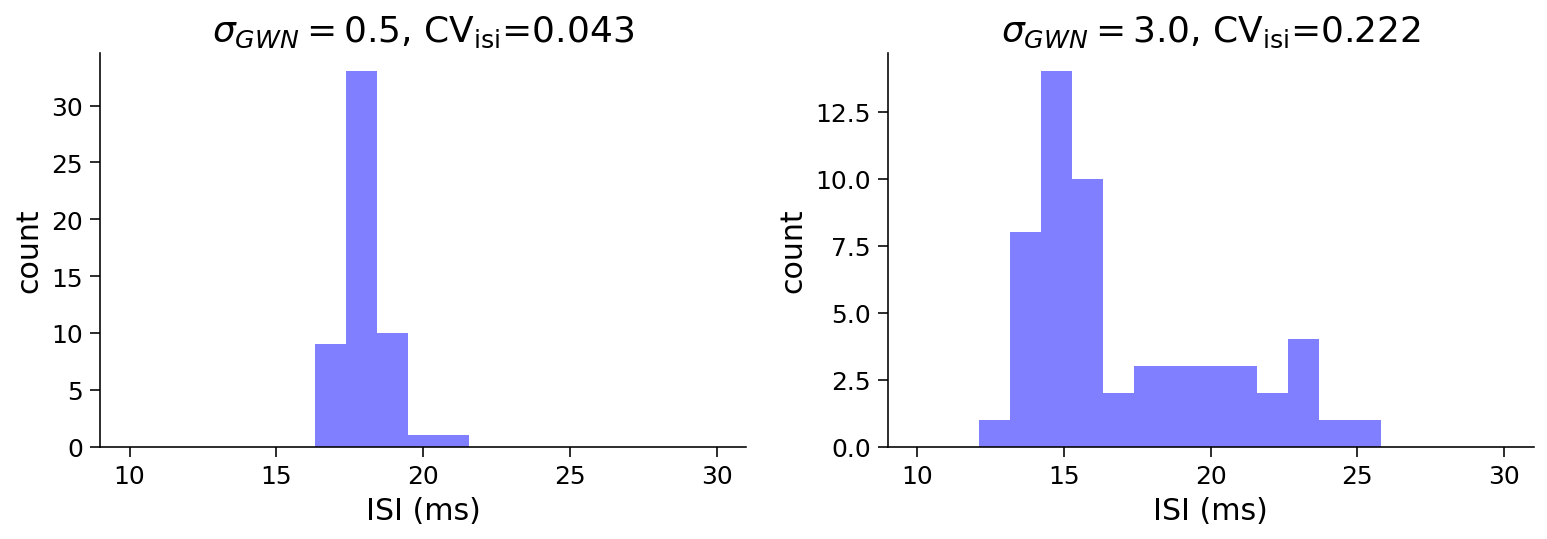

In [18]:
def isi_cv_LIF(spike_times):
  """
  Calculates the interspike intervals (isi) and
  the coefficient of variation (cv) for a given spike_train

  Args:
    spike_times : (n, ) vector with the spike times (ndarray)

  Returns:
    isi         : (n-1,) vector with the inter-spike intervals (ms)
    cv          : coefficient of variation of isi (float)

  """
  ########################################################################
  ## TODO for students: compute the membrane potential v, spike train sp #
  # Fill out function and remove
  #raise NotImplementedError('Student Exercise: calculate the isi and the cv!')
  ########################################################################
  if len(spike_times) >= 2:
    # Compute isi
    isi = np.diff(spike_times)
    # Compute cv
    cv = np.std(isi)/isi.mean()
  else:
    isi = np.nan
    cv = np.nan

  return isi, cv


# Set parameters
pars = default_pars(T=1000.)
mu_gwn = 250
sig_gwn1 = 0.5
sig_gwn2 = 3.0

# Run LIF model for sigma = 0.5
I_GWN1 = my_GWN(pars, mu=mu_gwn, sig=sig_gwn1, myseed=2020)
_, sp1 = run_LIF(pars, Iinj=I_GWN1)

# Run LIF model for sigma = 3
I_GWN2 = my_GWN(pars, mu=mu_gwn, sig=sig_gwn2, myseed=2020)
_, sp2 = run_LIF(pars, Iinj=I_GWN2)

# Compute ISIs/CV
isi1, cv1 = isi_cv_LIF(sp1)
isi2, cv2 = isi_cv_LIF(sp2)

# Visualize
my_hists(isi1, isi2, cv1, cv2, sig_gwn1, sig_gwn2)

In [19]:
#@title

#@markdown Make sure you execute this cell to enable the widget!

my_layout.width = '450px'
@widgets.interact(
    sig_gwn=widgets.FloatSlider(0.0, min=0., max=10.,
                                step=0.5, layout=my_layout)
)


def diff_std_affect_fI(sig_gwn):
  pars = default_pars(T=1000.)
  I_mean = np.arange(100., 400., 20)
  spk_count = np.zeros(len(I_mean))
  cv_isi = np.empty(len(I_mean))

  for idx in range(len(I_mean)):
    I_GWN = my_GWN(pars, mu=I_mean[idx], sig=sig_gwn)
    v, rec_spikes = run_LIF(pars, Iinj=I_GWN)
    spk_count[idx] = len(rec_spikes)
    if len(rec_spikes) > 3:
      isi = np.diff(rec_spikes)
      cv_isi[idx] = np.std(isi) / np.mean(isi)

  # Plot the F-I curve i.e. Output firing rate as a function of input mean.
  plt.figure()
  plt.plot(I_mean[spk_count > 5], cv_isi[spk_count > 5], 'bo', alpha=0.5)
  plt.xlabel('Average injected current (pA)')
  plt.ylabel(r'Spike irregularity ($\mathrm{CV}_\mathrm{ISI}$)')
  plt.ylim(-0.1, 1.5)
  plt.grid(True)
  plt.show()

interactive(children=(FloatSlider(value=0.0, description='sig_gwn', layout=Layout(width='450px'), max=10.0, st…

In [20]:
# @markdown Execute this cell to get helper function `my_OU`


def my_OU(pars, mu, sig, myseed=False):
  """
  Function that produces Ornstein-Uhlenbeck input

  Args:
    pars       : parameter dictionary
    sig        : noise amplitute
    myseed     : random seed. int or boolean

  Returns:
    I_ou       : Ornstein-Uhlenbeck input current
  """

  # Retrieve simulation parameters
  dt, range_t = pars['dt'], pars['range_t']
  Lt = range_t.size
  tau_ou = pars['tau_ou']  # [ms]

  # set random seed
  if myseed:
    np.random.seed(seed=myseed)
  else:
    np.random.seed()

  # Initialize
  noise = np.random.randn(Lt)
  I_ou = np.zeros(Lt)
  I_ou[0] = noise[0] * sig

  # generate OU
  for it in range(Lt-1):
    I_ou[it+1] = I_ou[it] + (dt / tau_ou) * (mu - I_ou[it]) + np.sqrt(2 * dt / tau_ou) * sig * noise[it + 1]

  return I_ou


help(my_OU)

Help on function my_OU in module __main__:

my_OU(pars, mu, sig, myseed=False)
    Function that produces Ornstein-Uhlenbeck input
    
    Args:
      pars       : parameter dictionary
      sig        : noise amplitute
      myseed     : random seed. int or boolean
    
    Returns:
      I_ou       : Ornstein-Uhlenbeck input current



In [21]:
# @title

# @markdown Remember to enable the widget by running the cell!

my_layout.width = '450px'
@widgets.interact(
  tau_ou=widgets.FloatSlider(10.0, min=5., max=20.,
                             step=2.5, layout=my_layout),
  sig_ou=widgets.FloatSlider(10.0, min=5., max=40.,
                             step=2.5, layout=my_layout),
  mu_ou=widgets.FloatSlider(190.0, min=180., max=220.,
                            step=2.5, layout=my_layout)
)


def LIF_with_OU(tau_ou=10., sig_ou=40., mu_ou=200.):
  pars = default_pars(T=1000.)
  pars['tau_ou'] = tau_ou  # [ms]

  I_ou = my_OU(pars, mu_ou, sig_ou)

  v, sp = run_LIF(pars, Iinj=I_ou)

  plt.figure(figsize=(12, 4))
  plt.subplot(121)
  plt.plot(pars['range_t'], I_ou, 'b', lw=1.0)
  plt.xlabel('Time (ms)')
  plt.ylabel(r'$I_{\mathrm{OU}}$ (pA)')
  plt.subplot(122)
  plot_volt_trace(pars, v, sp)
  plt.tight_layout()
  plt.show()

interactive(children=(FloatSlider(value=10.0, description='tau_ou', layout=Layout(width='450px'), max=20.0, mi…